# Gold - Plots

## 0. Setup

In [7]:
debugging = True

In [6]:
import findspark
import matplotlib.pyplot as plt

from shared import PaymentType

findspark.init()

In [3]:
from pyspark.sql import DataFrame
from pyspark.sql import functions as f
from pyspark.sql import types as t

from utils import setup_spark


from pyspark.sql import SparkSession


spark = (
    SparkSession.builder.config("spark.sql.adaptive.enabled", "true")
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true")
    .config("spark.executor.cores", "4")
    .config("spark.executor.memory", "4g")
    .config("spark.driver.memory", "2g")
    .getOrCreate()
)
spark.sparkContext.addPyFile("shared.py")


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/28 20:54:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/11/28 20:54:57 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [5]:
from schemas import schema_merged_silver
from shared import PATH_SILVER_MERGED

df: DataFrame = spark.read.schema(schema_merged_silver).parquet(PATH_SILVER_MERGED)

## 1. Plots

### City

25/11/28 18:06:25 WARN TaskSchedulerImpl: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources


<Axes: >

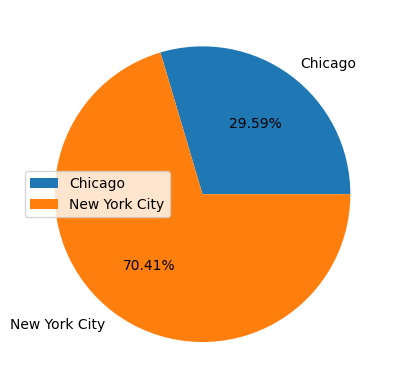

In [5]:
(
    df.groupBy("city")
    .count()
    .toPandas()
    .set_index("city")
    .plot.pie(
        y="count",
        autopct="%2.2f%%",
        ylabel="",
    )
)

### Duration

<Axes: xlabel='Duration (Minutes)', ylabel='Trips'>

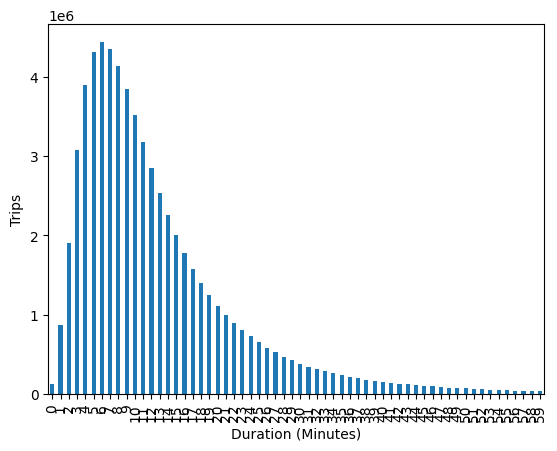

In [12]:
DURATION_MINUTES_MAX = 60

(
    df.groupBy("duration_minutes")
    .count()
    .orderBy("duration_minutes")
    .filter(f.col("duration_minutes") < DURATION_MINUTES_MAX)
    .toPandas()
    .plot.bar(
        x="duration_minutes",
        y="count",
        xlabel="Duration (Minutes)",
        ylabel="Trips",
        legend=False,
    )
)

### Speed

<Axes: xlabel='Speed (mph)', ylabel='Trips'>

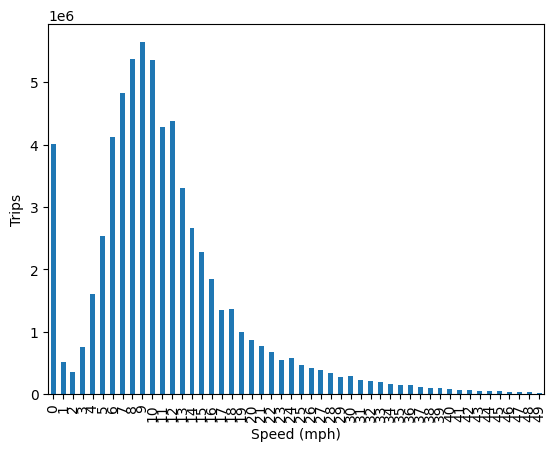

In [15]:
DURATION_MINUTES_MAX = 50

(
    df.withColumn("speed_mph", f.col("speed_mph").cast(t.IntegerType()))
    .groupBy("speed_mph")
    .count()
    .orderBy("speed_mph")
    .filter(f.col("speed_mph") < DURATION_MINUTES_MAX)
    .toPandas()
    .plot.bar(
        x="speed_mph",
        y="count",
        xlabel="Speed (mph)",
        ylabel="Trips",
        legend=False,
    )
)

### Tip Amount

<Axes: xlabel='Tip Amount (Cents)', ylabel='Trips'>

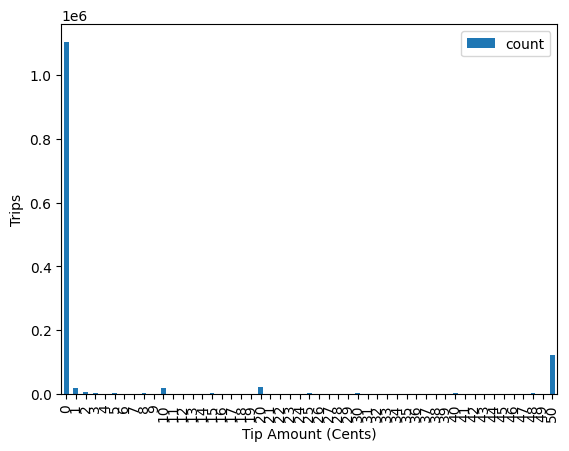

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/opt/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/socket.py", line 718, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


In [ ]:
from shared import City

TIP_MAX = 5000

(
    df.filter((f.col("payment_type") == PaymentType.CREDIT_CARD.value) & (f.col("city") == City.NYC.value))
    .withColumn("tip_amount", (f.col("tip_amount") * 100).cast(t.IntegerType()))
    .groupBy("tip_amount")
    .count()
    .orderBy("tip_amount")
    .filter(f.col("tip_amount").between(0, TIP_MAX))
    .toPandas()
    .plot.bar(
        x="tip_amount",
        y="count",
        xlabel="Tip Amount (Cents)",
        ylabel="Trips",
    )
)

### Tip Percentage

<Axes: xlabel='Tip (%)', ylabel='Trips'>

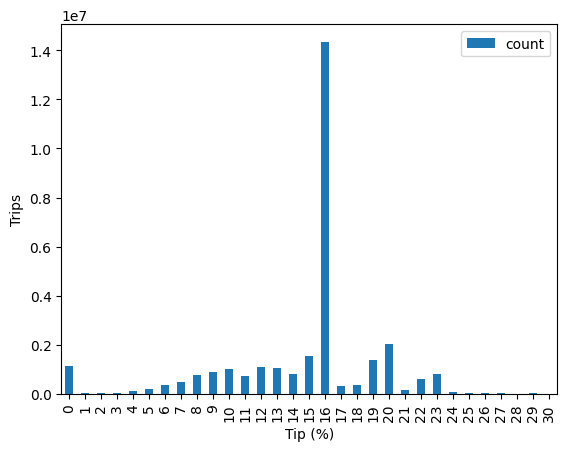

In [36]:
from shared import City

TIP_PCT_MAX = 30

(
    df.filter((f.col("payment_type") == PaymentType.CREDIT_CARD.value) & (f.col("city") == City.NYC.value))
    .withColumn("tip_pct", (f.col("tip_pct")).cast(t.IntegerType()))
    .groupBy("tip_pct")
    .count()
    .orderBy("tip_pct")
    .filter(f.col("tip_pct").between(0, TIP_PCT_MAX))
    .toPandas()
    .plot.bar(
        x="tip_pct",
        y="count",
        xlabel="Tip (%)",
        ylabel="Trips",
    )
)

### Start & End Time

<Axes: xlabel='Month', ylabel='Trips'>

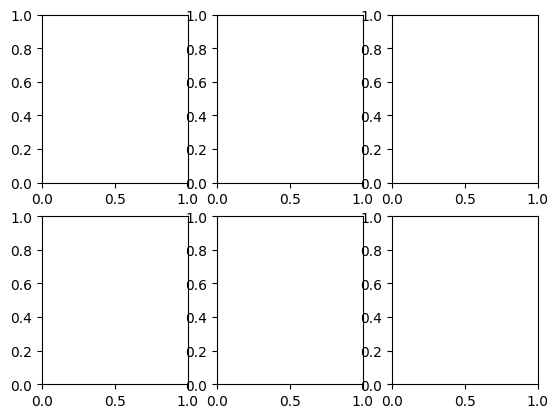

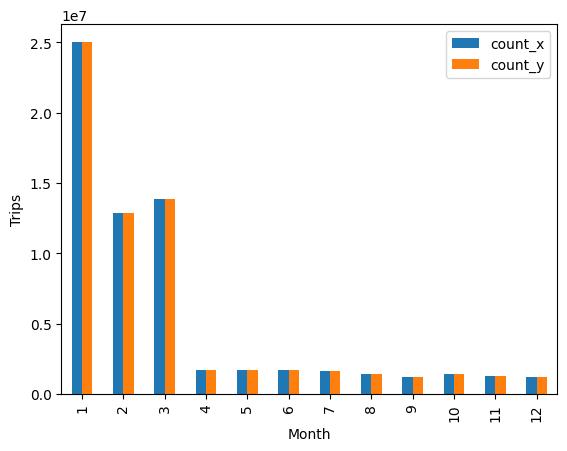

In [37]:
figure, ax = plt.subplots(nrows=2, ncols=3)

start_times = (
    df.filter(f.isnotnull("datetime_start"))
    .withColumn("hour", f.hour("datetime_start"))
    .withColumn("month", f.month("datetime_start"))
)
start_months = start_times.groupBy("month").count().orderBy("month").toPandas()
start_hours = start_times.groupBy("hour").count().orderBy("hour").toPandas()

end_times = (
    df.filter(f.isnotnull("datetime_end"))
    .withColumn("hour", f.hour("datetime_end"))
    .withColumn("month", f.month("datetime_end"))
)
end_hours = end_times.groupBy("hour").count().orderBy("hour").toPandas()
end_months = end_times.groupBy("month").count().orderBy("month").toPandas()


(
    start_months.merge(end_months, on="month").plot.bar(
        x="month",
        ylabel="Trips",
        xlabel="Month",
    )
)

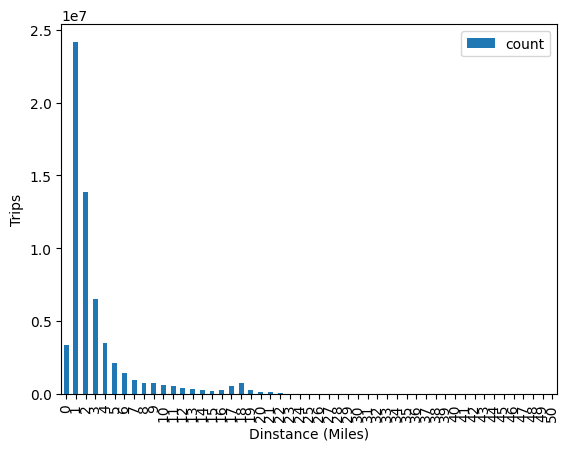

In [10]:
DISTANCE_MILES_MAX = 50

ax = (
    (
        df.filter(f.isnotnull("distance_miles"))
        .filter(f.col("distance_miles") > 0)
        .withColumn("distance_miles", f.round(f.col("distance_miles")).cast(t.IntegerType()))
        .filter(f.col("distance_miles") <= DISTANCE_MILES_MAX)
        .groupBy("distance_miles")
        .count()
        .orderBy("distance_miles")
    )
    .toPandas()
    .plot.bar(
        x="distance_miles",
        y="count",
        xlabel="Dinstance (Miles)",
        ylabel="Trips",
    )
)

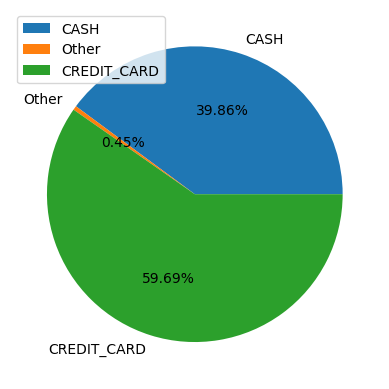

In [11]:
payment_types = df.withColumn(
    "payment_type",
    f.when(
        (f.col("payment_type") == PaymentType.CASH.value) | (f.col("payment_type") == PaymentType.CREDIT_CARD.value),
        f.col("payment_type"),
    ).otherwise(-1),
)
payment_counts = payment_types.groupBy("payment_type").count().toPandas().set_index("payment_type")

ax = payment_counts.plot.pie(
    y="count",
    autopct="%2.2f%%",
    ylabel="",
    labels=[PaymentType(p).name if p != -1 else "Other" for p in payment_counts.index],
)

In [23]:
FARE_AMOUNT_MAX = 60

ax = (
    (
        df.filter(f.isnotnull("fare_amount"))
        .withColumn("fare_amount", f.round(f.col("fare_amount")).cast(t.IntegerType()))
        .filter(f.col("fare_amount") <= FARE_AMOUNT_MAX)
        .groupBy("fare_amount")
        .count()
        .orderBy("fare_amount")
    )
    .toPandas()
    .plot.bar(
        x="fare_amount",
        y="count",
        xlabel="Fare ($)",
        ylabel="Trips",
    )
)

RuntimeError: SparkContext or SparkSession should be created first.

In [13]:
# TODO
_ = """
EXTRA_AMOUNT_MAX = 7

ax = (
    (
        df.filter(f.isnotnull("extra_amount"))
        .filter(f.col("extra_amount") > 0)
        .filter(f.col("extra_amount") <= EXTRA_AMOUNT_MAX)
        .withColumn("extra_amount", (f.col("extra_amount") * 10).cast(t.IntegerType()))
        .groupBy("extra_amount")
        .count()
        .orderBy("extra_amount")
    )
    .toPandas()
    .plot.bar(
        x="extra_amount",
        y="count",
        xlabel="Extra ($)",
        ylabel="Trips",
    )
)
"""

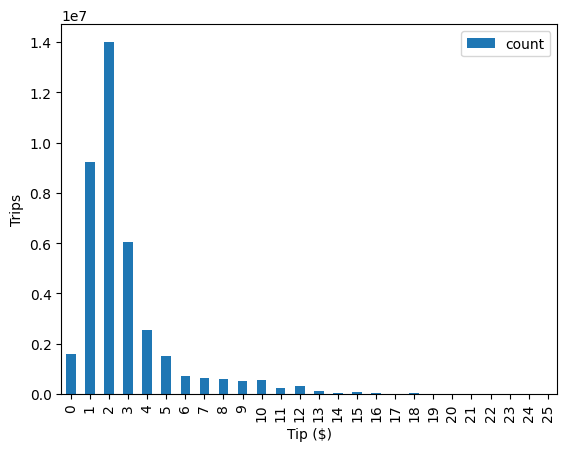

In [14]:
TIP_AMOUNT_MAX = 25

ax = (
    (
        df.filter(f.isnotnull("tip_amount"))
        .filter(f.col("payment_type") == PaymentType.CREDIT_CARD.value)
        .withColumn("tip_amount", f.round(f.col("tip_amount")).cast(t.IntegerType()))
        .filter(f.col("tip_amount") <= TIP_AMOUNT_MAX)
        .groupBy("tip_amount")
        .count()
        .orderBy("tip_amount")
    )
    .toPandas()
    .plot.bar(
        x="tip_amount",
        y="count",
        xlabel="Tip ($)",
        ylabel="Trips",
    )
)

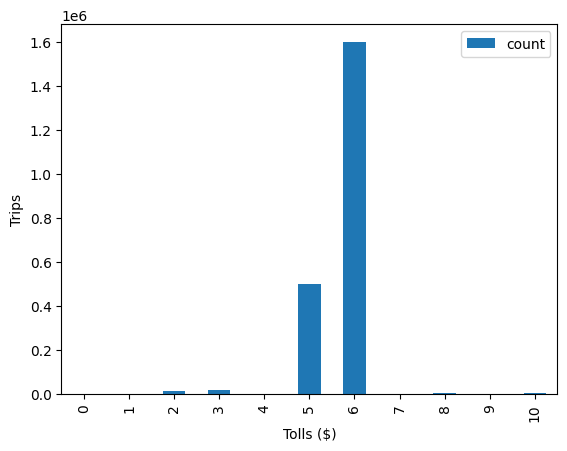

In [15]:
TOLLS_AMOUNT_MAX = 10

ax = (
    (
        df.filter(f.col("tolls_amount") > 0)
        .withColumn("tolls_amount", f.round(f.col("tolls_amount")).cast(t.IntegerType()))
        .filter(f.col("tolls_amount") <= TOLLS_AMOUNT_MAX)
        .groupBy("tolls_amount")
        .count()
        .orderBy("tolls_amount")
    )
    .toPandas()
    .plot.bar(
        x="tolls_amount",
        y="count",
        xlabel="Tolls ($)",
        ylabel="Trips",
    )
)

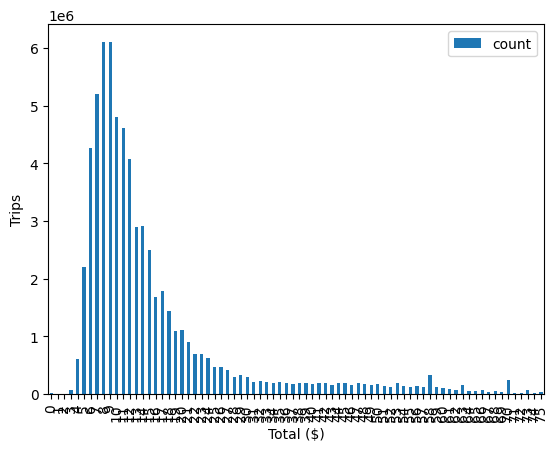

In [16]:
TOTAL_AMOUNT_MAX = 75

ax = (
    (
        df.filter(f.col("total_amount") > 0)
        .withColumn("total_amount", f.round(f.col("total_amount")).cast(t.IntegerType()))
        .filter(f.col("total_amount") <= TOTAL_AMOUNT_MAX)
        .groupBy("total_amount")
        .count()
        .orderBy("total_amount")
    )
    .toPandas()
    .plot.bar(
        x="total_amount",
        y="count",
        xlabel="Total ($)",
        ylabel="Trips",
    )
)

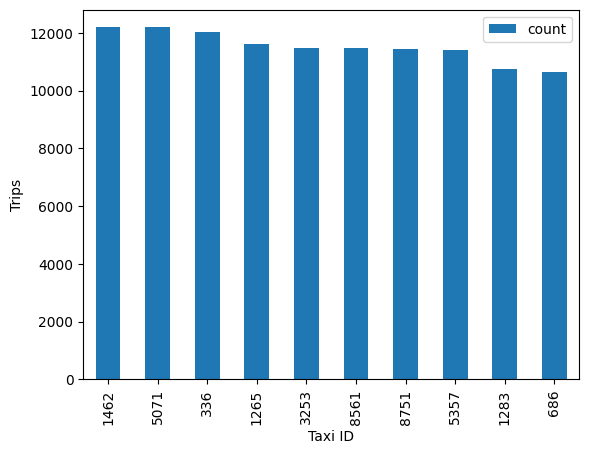

In [17]:
TAXI_ID_COUNT = 10

ax = (
    df.filter(f.col("taxi_id_chi").isNotNull())
    .groupBy("taxi_id_chi")
    .count()
    .orderBy(f.col("count").desc())
    .limit(TAXI_ID_COUNT)
    .toPandas()
    .plot.bar(
        x="taxi_id_chi",
        y="count",
        xlabel="Taxi ID",
        ylabel="Trips",
    )
)

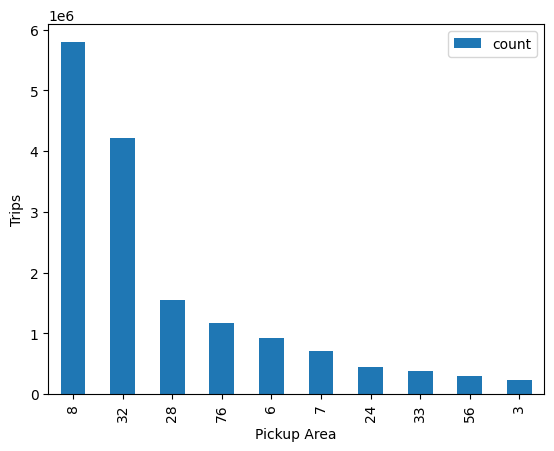

In [18]:
COMMUNITY_AREA_PICKUP_COUNT = 10

ax = (
    df.filter(f.col("community_area_pickup_chi").isNotNull())
    .groupBy("community_area_pickup_chi")
    .count()
    .orderBy(f.col("count").desc())
    .limit(TAXI_ID_COUNT)
    .toPandas()
    .plot.bar(
        x="community_area_pickup_chi",
        y="count",
        xlabel="Pickup Area",
        ylabel="Trips",
    )
)

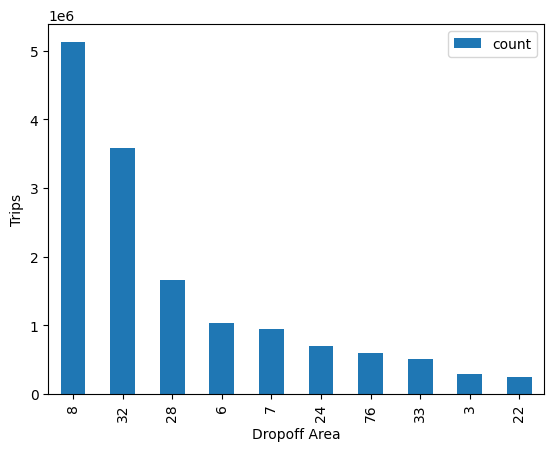

In [19]:
COMMUNITY_AREA_DROPOFF_COUNT = 10

ax = (
    df.filter(f.col("community_area_dropoff_chi").isNotNull())
    .groupBy("community_area_dropoff_chi")
    .count()
    .orderBy(f.col("count").desc())
    .limit(TAXI_ID_COUNT)
    .toPandas()
    .plot.bar(
        x="community_area_dropoff_chi",
        y="count",
        xlabel="Dropoff Area",
        ylabel="Trips",
    )
)

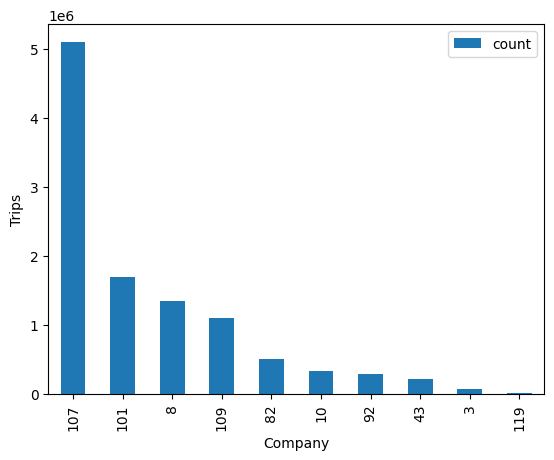

In [20]:
COMPANY_COUNT = 10

ax = (
    df.filter(f.col("company_chi").isNotNull())
    .groupBy("company_chi")
    .count()
    .orderBy(f.col("count").desc())
    .limit(TAXI_ID_COUNT)
    .toPandas()
    .plot.bar(
        x="company_chi",
        y="count",
        xlabel="Company",
        ylabel="Trips",
    )
)

In [21]:
spark.stop()